# 🥥 Coconut Mite Detection - Local Training

**Optimized for RTX 3050 + 32GB RAM**

No cloud upload needed - train directly on your machine!

## 1. Setup & GPU Check

In [1]:
# Check GPU
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("\n" + "="*50)
print("GPU STATUS")
print("="*50)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Found: {gpus}")
    # Enable memory growth to avoid OOM
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ Memory growth enabled")
else:
    print("❌ No GPU found! Check CUDA installation")

TensorFlow Version: 2.20.0

GPU STATUS
❌ No GPU found! Check CUDA installation


In [ ]:
# Install dependencies if needed
# Run this in terminal first:
# pip install tensorflow opencv-python albumentations scikit-learn matplotlib seaborn tqdm

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import json
import cv2
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Albumentations
import albumentations as A

print("\n✅ All libraries imported!")


✅ All libraries imported!


## 2. Configuration

In [3]:
# ============================================
# PATHS - Already set for your local machine
# ============================================
DATA_DIR = Path(r'D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\data\raw\pest')
MODEL_DIR = Path(r'D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite')

# Create model directory
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ============================================
# MODEL CONFIGURATION (Optimized for RTX 3050 4GB)
# ============================================
CONFIG = {
    # Image settings
    'img_size': 224,
    'channels': 3,
    
    # Training settings (optimized for 4GB VRAM)
    'batch_size': 16,          # Reduced for 4GB VRAM
    'epochs': 100,
    'learning_rate': 1e-4,
    'min_lr': 1e-7,
    
    # Data split
    'test_split': 0.15,
    'val_split': 0.15,
    
    # Classes
    'classes': ['coconut_mite', 'healthy'],
    'num_classes': 2,
    
    # Seed
    'seed': 42
}

# Set seeds
np.random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

print("Data Directory:", DATA_DIR)
print("Model Directory:", MODEL_DIR)
print("\nConfiguration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Data Directory: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\data\raw\pest
Model Directory: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite

Configuration:
  img_size: 224
  channels: 3
  batch_size: 16
  epochs: 100
  learning_rate: 0.0001
  min_lr: 1e-07
  test_split: 0.15
  val_split: 0.15
  classes: ['coconut_mite', 'healthy']
  num_classes: 2
  seed: 42


## 3. Load & Check Data

In [4]:
# Check data folders
print("="*50)
print("DATA CHECK")
print("="*50)

for class_name in CONFIG['classes']:
    class_path = DATA_DIR / class_name
    if class_path.exists():
        count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
        print(f"✅ {class_name}: {count:,} images")
    else:
        print(f"❌ {class_name}: Folder not found!")
        print(f"   Expected path: {class_path}")

DATA CHECK
✅ coconut_mite: 4,747 images
✅ healthy: 4,228 images


In [5]:
# Load dataset
def load_dataset(data_dir, classes):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        if not class_dir.exists():
            print(f"⚠️ Skipping {class_name} - folder not found")
            continue
        
        for img_path in tqdm(list(class_dir.glob('*')), desc=f"Loading {class_name}"):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                images.append(str(img_path))
                labels.append(class_idx)
    
    return np.array(images), np.array(labels)

X, y = load_dataset(DATA_DIR, CONFIG['classes'])

print(f"\n✅ Total images loaded: {len(X):,}")
for idx, class_name in enumerate(CONFIG['classes']):
    count = np.sum(y == idx)
    print(f"   {class_name}: {count:,}")

Loading healthy: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4228/4228 [00:00<00:00, 224202.45it/s]


✅ Total images loaded: 8,975
   coconut_mite: 4,747
   healthy: 4,228


In [6]:
# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=CONFIG['test_split'], stratify=y, random_state=CONFIG['seed']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=CONFIG['val_split']/(1-CONFIG['test_split']), 
    stratify=y_temp, random_state=CONFIG['seed']
)

print(f"\nData Split:")
print(f"  Training:   {len(X_train):,}")
print(f"  Validation: {len(X_val):,}")
print(f"  Test:       {len(X_test):,}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weights_dict}")


Data Split:
  Training:   6,281
  Validation: 1,347
  Test:       1,347

Class weights: {0: np.float64(0.945364238410596), 1: np.float64(1.0613382899628252)}


## 4. Data Augmentation & Generator

In [7]:
# Augmentation pipelines
def get_augmentation(mode='train'):
    if mode == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
            ], p=0.5),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 5), p=1),
                A.GaussNoise(var_limit=(10, 50), p=1),
            ], p=0.2),
            A.CoarseDropout(max_holes=8, max_height=28, max_width=28, fill_value=0, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

print("✅ Augmentation pipelines created!")

✅ Augmentation pipelines created!


In [8]:
# Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, augmentation, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = self.image_paths[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        X = np.zeros((len(batch_paths), CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.float32)
        y = keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)
        
        for i, path in enumerate(batch_paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = self.augmentation(image=img)
            X[i] = augmented['image']
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create generators
train_gen = DataGenerator(X_train, y_train, CONFIG['batch_size'], get_augmentation('train'), CONFIG['num_classes'], shuffle=True)
val_gen = DataGenerator(X_val, y_val, CONFIG['batch_size'], get_augmentation('val'), CONFIG['num_classes'], shuffle=False)
test_gen = DataGenerator(X_test, y_test, CONFIG['batch_size'], get_augmentation('val'), CONFIG['num_classes'], shuffle=False)

print(f"✅ Generators created!")
print(f"   Train batches: {len(train_gen)}")
print(f"   Val batches: {len(val_gen)}")
print(f"   Test batches: {len(test_gen)}")

✅ Generators created!
   Train batches: 393
   Val batches: 85
   Test batches: 85


## 5. Create Model

In [9]:
def create_model(input_shape, num_classes):
    """Create EfficientNetB0 model (best for RTX 3050)"""
    
    # Base model
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    # Build model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model, base_model

# Create model
input_shape = (CONFIG['img_size'], CONFIG['img_size'], CONFIG['channels'])
model, base_model = create_model(input_shape, CONFIG['num_classes'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,415,781 (16.84 MB)

 Trainable params: 363,650 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=CONFIG['min_lr'], verbose=1),
    TensorBoard(log_dir=str(MODEL_DIR / 'logs'), histogram_freq=1)
]

print("✅ Callbacks configured!")

✅ Callbacks configured!


## 6. Training - Phase 1 (Feature Extraction)

In [11]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate']),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

print("="*60)
print("PHASE 1: Training Classification Head")
print("="*60)

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

PHASE 1: Training Classification Head
Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.5777 - loss: 6.4113
Epoch 1: val_accuracy improved from None to 0.74833, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite\best_model.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.6002 - loss: 6.0634 - val_accuracy: 0.7483 - val_loss: 5.3670 - learning_rate: 1.0000e-04
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6585 - loss: 5.1486
Epoch 2: val_accuracy improved from 0.74833 to 0.81143, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite\best_model.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 338s 860ms/step - accuracy: 0.6661 - loss: 4.8865 - val_accuracy: 0.8114 - val_loss: 4.2788 - learning_rate: 1.0000e-04
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6856 - loss: 4.1668
Epoch 3: val_accuracy improved from 0.81143 to 0.81440, saving model t

## 7. Training - Phase 2 (Fine-tuning)

In [12]:
# Unfreeze top layers
print("\n" + "="*60)
print("PHASE 2: Fine-tuning Top Layers")
print("="*60)

base_model.trainable = True

# Freeze all except last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower LR
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate'] / 10),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=CONFIG['epochs'],
    initial_epoch=len(history1.history['loss']),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)


PHASE 2: Fine-tuning Top Layers
Epoch 21/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.6032 - loss: 0.7864
Epoch 21: val_accuracy did not improve from 0.88716
393/393 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.6376 - loss: 0.7524 - val_accuracy: 0.7231 - val_loss: 0.6504 - learning_rate: 1.0000e-05
Epoch 22/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6906 - loss: 0.6986
Epoch 22: val_accuracy did not improve from 0.88716
393/393 ━━━━━━━━━━━━━━━━━━━━ 335s 854ms/step - accuracy: 0.6911 - loss: 0.6931 - val_accuracy: 0.7869 - val_loss: 0.5893 - learning_rate: 1.0000e-05
Epoch 23/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7087 - loss: 0.6758
Epoch 23: val_accuracy did not improve from 0.88716
393/393 ━━━━━━━━━━━━━━━━━━━━ 342s 871ms/step - accuracy: 0.7157 - loss: 0.6697 - val_accuracy: 0.8337 - val_loss: 0.5457 - learning_rate: 1.0000e-05
Epoch 24/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.7231 - loss: 0.6673
Epoch 2

## 8. Evaluation

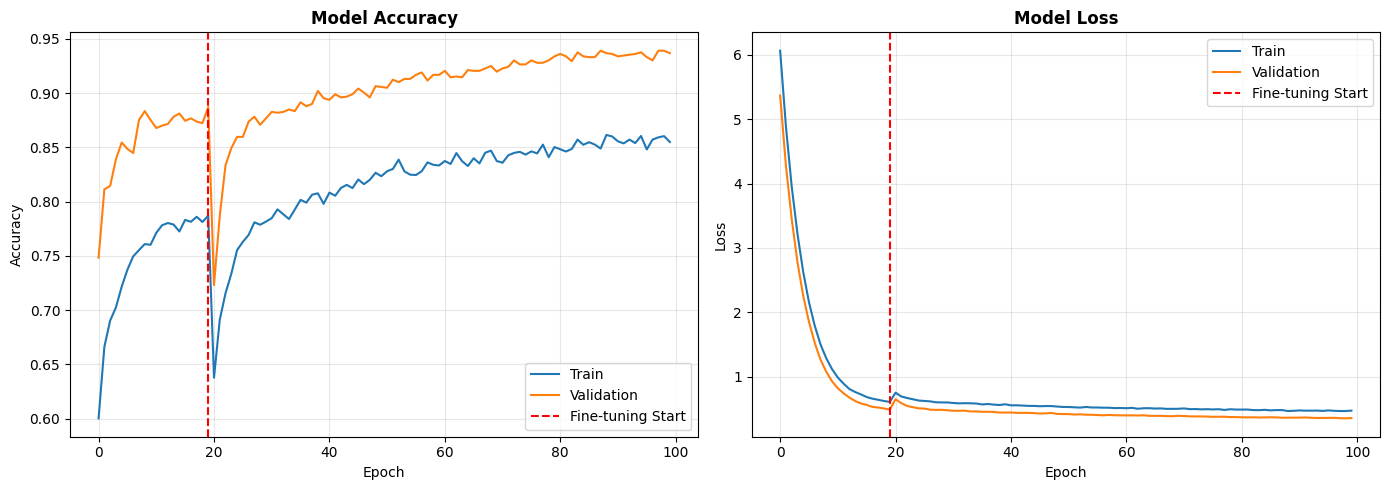

In [13]:
# Combine histories
history = {}
for key in history1.history.keys():
    history[key] = history1.history[key] + history2.history[key]

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['accuracy'], label='Train')
axes[0].plot(history['val_accuracy'], label='Validation')
axes[0].axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning Start')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['loss'], label='Train')
axes[1].plot(history['val_loss'], label='Validation')
axes[1].axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning Start')
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=150)
plt.show()

In [14]:
# Evaluate on test set
print("="*50)
print("TEST SET EVALUATION")
print("="*50)

test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predictions
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=CONFIG['classes']))

TEST SET EVALUATION

Test Loss: 0.3343
Test Accuracy: 95.62%
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 578ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

coconut_mite       0.97      0.94      0.96       712
     healthy       0.94      0.97      0.95       635

    accuracy                           0.96      1347
   macro avg       0.96      0.96      0.96      1347
weighted avg       0.96      0.96      0.96      1347



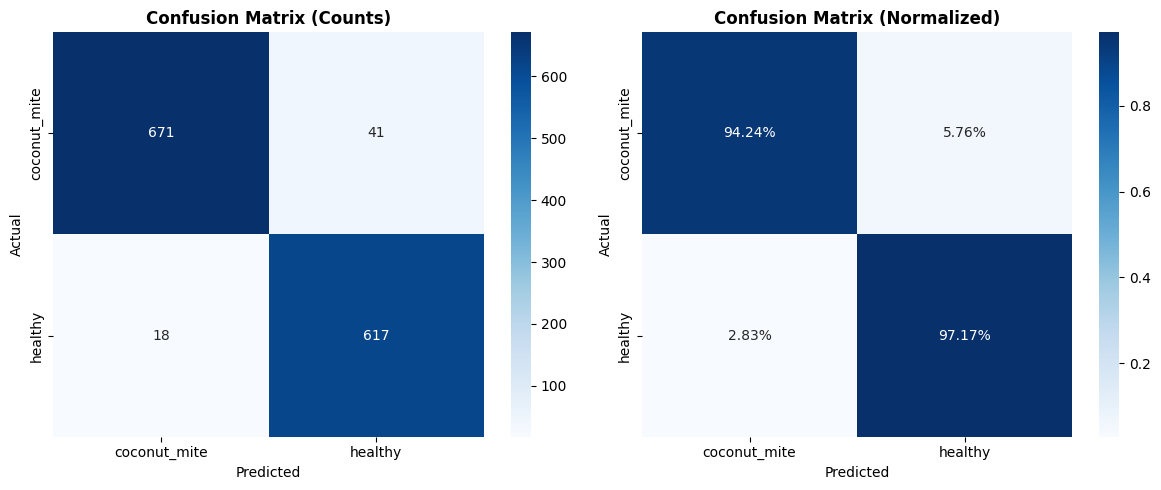

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CONFIG['classes'], yticklabels=CONFIG['classes'])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=CONFIG['classes'], yticklabels=CONFIG['classes'])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=150)
plt.show()

## 9. Save Model

In [17]:
print("="*50)
print("SAVING MODEL")
print("="*50)

# Keras format
model.save(MODEL_DIR / 'coconut_mite_model.keras')
print(f"✅ Keras model saved")

# H5 format
model.save(MODEL_DIR / 'coconut_mite_model.h5')
print(f"✅ H5 model saved")

# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_DIR / 'coconut_mite_model.tflite', 'wb') as f:
    f.write(tflite_model)
print(f"✅ TFLite model saved")

# Model info
model_info = {
    'model_name': 'EfficientNetB0',
    'input_shape': [CONFIG['img_size'], CONFIG['img_size'], 3],
    'classes': CONFIG['classes'],
    'test_accuracy': float(test_acc),
    'normalization': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]},
    'training_date': datetime.datetime.now().isoformat()
}

with open(MODEL_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✅ Model info saved")

SAVING MODEL


✅ Keras model saved
✅ H5 model saved
INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpfwx6tws9\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpfwx6tws9\assets


Saved artifact at 'C:\Users\DELL\AppData\Local\Temp\tmpfwx6tws9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1489729330576: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1489729329808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1489724602512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724601360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724601744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724603472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724601552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724602128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724602320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1489724601936: TensorSpec(shape=(), dtype=tf.resourc

In [18]:
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print(f"\n📊 Test Accuracy: {test_acc*100:.2f}%")
print(f"📁 Models saved to: {MODEL_DIR}")
print("\n📁 Saved files:")
for f in MODEL_DIR.glob('*'):
    print(f"   • {f.name}")


🎉 TRAINING COMPLETE!

📊 Test Accuracy: 95.62%
📁 Models saved to: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite

📁 Saved files:
   • best_model.keras
   • class_distribution.png
   • coconut_mite_model.h5
   • coconut_mite_model.keras
   • coconut_mite_model.tflite
   • confusion_matrix.png
   • image_analysis.png
   • logs
   • model_info.json
   • training_history.png
